In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, LAKES, BORDERS
import matplotlib.ticker as mticker

import sympy as sym
from sympy import symbols, Eq

import warnings
warnings.filterwarnings("ignore")    

## PSV Data analysis comparison: 16 Degree Bin Location Grouping and Residual from $I_{GAD}$ Plots

### Location Grouping by 10 degree latitude bins for a total of 16 data groups

In [2]:
#Image(filename='magnetic_field_compenents_tauxe.png', width=800, height=1400)

In [3]:
pd.set_option('display.max_rows', 10)            # set dataframe display
psv = pd.read_csv('..\..\data\PSV0.csv')            # import csv file as pandas dataframe (df)
psv.columns

Index(['age', 'age_pm', 'age_high', 'age_low', 'site_lat', 'site_lon',
       'model_lat', 'model_lon', 'nn', 'k', 'dec', 'inc', 'model_vgp_lat',
       'model_vgp_lon', 'site_ID'],
      dtype='object')

In [4]:
psvdf = pd.DataFrame() 
# adding columns from imported 'psv' df to new psvnew df and re-naming them 
psvdf['Model_lat'] = psv.model_lat              # latitude
psvdf['Model_lon'] = psv.model_lon              # longitude
psvdf['Model_vgp_lat'] = psv.model_vgp_lat
psvdf['AGE'] = psv.age                          # estimated age
psvdf['AGE_pm'] = psv.age_pm                   
psvdf['AGE_high'] = psv.age_high
psvdf['AGE_low'] = psv.age_low
psvdf['Dec'] = psv.dec                          # declination
psvdf['Inc'] = psv.inc                          # inclination
psvdf['K'] = psv.k                              # precision parameter
psvdf.reset_index(inplace=True, drop=True) # reset index 

In [5]:
# normal polarity df
psv05N = psvdf.loc[(psvdf.AGE <= 5) & (psvdf.Model_vgp_lat > 0)] # sort the date for age less than or equal to 10 MA and Model VGP lat > or = 0
# reverse polarity df
psv05R = psvdf.loc[(psvdf.AGE <= 5) & (psvdf.Model_vgp_lat < 0)] # sort the date for age less than or equal to 10 MA and Model VGP lat > or = 0
psv05R['Inc'] = -psv05R.Inc
psv05R['Dec'] = psv05R.Dec - 180
psv05NR = pd.concat([psv05N,psv05R])

psv_05N = psv05N.sort_values(by='Model_lat') # sort by increasing Latitude values
psv_05R = psv05R.sort_values(by='Model_lat') 
psv_05NR = psv05NR.sort_values(by='Model_lat') 

psv_05N.reset_index(inplace=True)            # reset index column
psv_05R.reset_index(inplace=True)            # reset index column
psv_05NR.reset_index(inplace=True)            # reset index column

psvs = [psv_05N,psv_05R,psv_05NR]
print('PSV10 Age 0-5 Normal Data Points:', len(psv_05N), '\nPSV10 Age 0-5 Reverse Data Points:', len(psv_05R), 
      '\nPSV10 Age 0-5 Normal and Reverse Data Points:', len(psv_05NR))

PSV10 Age 0-5 Normal Data Points: 1635 
PSV10 Age 0-5 Reverse Data Points: 600 
PSV10 Age 0-5 Normal and Reverse Data Points: 2235


#### Plot of all data points being used in this analysis

In [6]:
# plt.figure(figsize=(14, 14))
# ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-90))

# gl=ax.gridlines(crs=ccrs.PlateCarree(),color='black',linewidth=1,linestyle='dotted')
# gl.top_labels = False
# gl.ylocator=mticker.FixedLocator(np.arange(-90,91,30))
# gl.xlocator=mticker.FixedLocator(np.arange(0,400,30));
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# plt.title('Data Locations from the Past 5 Ma', fontsize=15)

# ax.add_feature(OCEAN,color='lightblue')
# ax.add_feature(LAND,color='green')
# ax.add_feature(LAKES,facecolor='lightblue',edgecolor='black')

# ax.plot([psvnew.Model_lon.values],[psvnew.Model_lat.values],marker='o',color='blue',\
#         markersize=10,transform=ccrs.Geodetic(), markeredgecolor='black')

# pintlocs = pd.read_pickle("../PINT/PINT_05NR.pkl")
# ax.plot([pintlocs.SLONG.values],[pintlocs.SLAT.values],marker='o',color='m',\
#         markersize=10,transform=ccrs.Geodetic(),markeredgecolor='black')

# import matplotlib.patches as mpatches
# psv_10 = mpatches.Patch(color='blue', label='PSV10')
# PINT = mpatches.Patch(color='m', label='PINT')
# plt.legend(fontsize=14,handles=[psv_10,PINT])

# ax.set_global()

# ax.coastlines();

# plt.savefig('../../figs/' + 'PINT_PSV10_05NR_map.png', dpi=150)

#### This function returns a bin label within -8 to 8 corresponding to the specified 10 degree range. Based on how this criteria is applied to the Latitude column, the "bins" column is created. 

In [7]:
pd.set_option('display.max_rows', 10)

psvs_binned = []

for df in psvs: 
    #df = psvnewn.iloc[:]             # copy table to a new one as to not revert previous setting on table

    # in a new column called bins, assign labels -8 to 8 to each data point corresponding to -80 to 80 degrees by 10 degree incriments
    df['bins'] = pd.cut(x=df['Model_lat'], bins=[-80.0, -70.0, -60.0, -50.0, -40.0, -30.0, 
                                            -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 
                                            60.0, 70.0, 80.0], 
                   labels=[-8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8], right=False)
    del df['index']                  # delete extra index the gets created due to pd.cut
    
    #can be seperated here to analyze bin size in cromwell 0-10N analysis 
    
    df["Igad"] = np.degrees(np.arctan(2*np.tan(np.radians(df.Model_lat))))   # inputs latitude as radians into the tan function and outputs a value in degrees
    df["Istdv_Fisher"] = 81/np.sqrt(np.abs(df["K"])) # inc stdv 

    df["ΔI"] =  ((df["Inc"]) - df["Igad"])           # inclination anamoly in degrees
    df["AGE_unc"] = df["AGE_high"] - df["AGE_low"]     # age uncertainty
    
    latr = np.radians(df.Model_lat)                    # converts Lat and Long values from degrees into radians
    longr = np.radians(df.Model_lon)

    df['X']= np.cos(latr)*np.cos(longr)                # convert Lat and Long to cartesian X,Y,Z coordinates and creates X, Y, and Z columns 
    df['Y']= np.cos(latr)*np.sin(longr)
    df['Z']= np.sin(latr)

    decr = np.radians(df.Dec)                          # converts Dec and Inc degree values into radians
    incr = np.radians(df.Inc)

    df['X2']= np.cos(incr)*np.cos(decr)                # convert dec and inc to cartesian X,Y,Z coordinates and creates X2, Y2, and Z2 columns 
    df['Y2']= np.cos(incr)*np.sin(decr)
    df['Z2']= np.sin(incr)
    psvs_binned.append(df)

In [8]:
#psvs_binned[0]=psv_05N, psvs_binned[1]=psv_05R, psvs_binned[2]=psv_05NR
#psvs_binned[2]

#### Comparing method to Cromwell method on 0-10 N data in which there are 1753 data pts

In [9]:
# # To be ran when comparing method to cromwell method on 0-10 N data in which there are 1753 data pts
# #This attaches each group bin to its own dataframe. The array is made up of the lengths of each of the bins. In this format, 
# #it can be compared to the groups in the Cromwell paper to ensure that this grouping method returns the same number of groups achieved in the paper. bins = df['bins'].unique()


# # empty array to be filled with bin dfs
# bins_dfs = []

# for binval in bins:
#     bin_frame = psvs_binned[0].loc[df.bins == binval]
#     bins_dfs.append(bin_frame)
    
# #bins_dfs[0]



# # creates an array with each value representing the length of the group for that bins value
# arr_0 = np.array([len(bins_dfs[0]), len(bins_dfs[1]), len(bins_dfs[2]), len(bins_dfs[3]), len(bins_dfs[4]), len(bins_dfs[5]), len(bins_dfs[6]), len(bins_dfs[7]),
#        len(bins_dfs[8]), len(bins_dfs[9]), len(bins_dfs[10]), len(bins_dfs[11]), len(bins_dfs[12]), len(bins_dfs[13]), len(bins_dfs[14]), len(bins_dfs[15])])

# print(arr_0, 'sum:', sum(arr_0))

# #This shows that the group lengths are the same (both having 1753 data points)

# #group amounts from Cromwell et al. Fig. 8, b)
# papergroups = [77, 35, 24, 35, 96, 88, 77, 169, 86, 184, 323, 154, 198, 119, 57, 31]
# np.sum(papergroups)

# #This array subtracts the two arrays containing group amounts and returns a zero matrix that indicates the groups are the same in length. 
# papergroups - arr_0

# #print df to show there are 1753 data points
# pd.set_option('display.max_rows', 10)
# df       

#### Igad calculations
$I_{gad}$ is the inclination expected from the GAD field and will be calculated using: 
$$tan(I_{gad}) = 2tan(λ)$$
$$I_{gad} = atan(2tan(λ))$$

In order to average over the latitude and longitude for the groups, each will first be converted to their x,y,z coordinates.

Declination and inclination directions will be transformed into cartesian coordinates $x_{2}, y_{2}, z_{2}$:
$$ x_{2} = cos(D)cos(I)$$ 
$$ y_{2} = sin(D)cos(I)$$ 
$$ z_{2} = sin(I)$$ 

In [10]:
# X_col = df.columns.get_loc("X")       # creates a call for X,Y,Z cartesian coord of lat and long for later 
# Y_col = df.columns.get_loc("Y")
# Z_col = df.columns.get_loc("Z")
# apsvnewn =  df.iloc[:, X_col:Z_col+1].values # each row needs its own x,y,z array

In [11]:
# may include min and max latitudes per group if need but will be ignored now
#lat_mincal = min(latgroup)
#lat_maxcal = max(latgroup)

The conversion from cartesian coordinates to angular coordinates of latitude and longitude:
$$lt = asin(z)$$
$$lg = atan2(y,x)$$

The conversion from cartesian coordinates to angular coordinates of declination and inclination:
$$D = atan2(y_{2},x_{2})$$
$$I = asin(z_{2})$$

This function includes severval averaging calculations for the groups baased on the bins column. The calculations includes in this function result in the average group latitude and longitude, declination and inclination, scalar value for Igad, residual standard deviation, weighted residual standard deviation, average residual, weighted Fisher scalar standard deviation, the size of the group, the age range of the group, and the minimum and maximum ages for each group. 

#### Calculate group avgs will be added to grouping_essentials.py

In [12]:
def calculate_group_avgs(dataframe_group):
    # calculates the scalar standard deviation of the recorded Inclination
    dataframe_group['Istdv_scalar'] = np.sqrt(np.abs(np.mean(dataframe_group['Inc'])))

# calculates avg lat and long for group 
    x = np.average(dataframe_group['X'])
    y = np.average(dataframe_group['Y'])
    z = np.average(dataframe_group['Z'])

    lt = np.degrees(np.arcsin(z))                                         # converts averaged cartesian location to latitude in degrees 
    lg = np.degrees(np.arctan2(y,x))                                      # converts averaged cartesian location to longitude in degrees      

    dataframe_group['AvgLat'] = lt 
    dataframe_group['AvgLong'] = lg
    
# calculates avg dec and avg inc                    
    r = np.sqrt((sum(dataframe_group['X2']))**2 + (sum(dataframe_group['Y2']))**2 + (sum(dataframe_group['Z2']))**2)
    
    x2 = (1/r)*sum(dataframe_group['X2'])            # averages the cartesian x coord
    y2 = (1/r)*sum(dataframe_group['Y2'])            # averages the cartesian y coord
    z2 = (1/r)*sum(dataframe_group['Z2'])
      
    #print("z2=",z2)
    #print("r=",r)
    
    inc = np.degrees(np.arcsin(z2))
    dec = np.degrees(np.arctan2(y2,x2))    
        
    dataframe_group['AvgDec'] = dec
    dataframe_group['AvgInc'] = inc
        
# calculates the Igad averages over the groups
    dataframe_group['AvgIgad(scalar)'] = np.average(dataframe_group['Igad'])

# length of the group
    dataframe_group['GroupAmount'] = len(dataframe_group)

# calls the I stdv col for a group from: df["I stdv"] = 81/np.sqrt(np.abs(df["K"])) 
# the standard deviation of Istdv Fisher divided by N, amount of data points in group 
    dataframe_group['Istdvgroup_weighted'] = np.std(dataframe_group['Istdv_Fisher'])/np.sqrt(len(dataframe_group))

# calls the ΔI column from: df["\u0394I"] =  ((df["Inc"]) - df["Igad"])
# non-weighted ΔI stdv
    dataframe_group['ΔIstdv'] = np.std(dataframe_group['ΔI'])

# weighted ΔI stdv = stdv of ΔI for a group divided by N
    dataframe_group['ΔIstdv_weighted'] = np.std(dataframe_group['ΔI'])/ np.sqrt(len(dataframe_group))

# average of the non-weighted ΔI stdv
    dataframe_group['ΔIAvg(scalar)'] = np.average(dataframe_group['ΔI'])   

# range of a group
    #dataframe_group['Age Range'] = (max(dataframe_group['AGE']) - min(dataframe_group['AGE']))

# minimum of an age range for a group
    #dataframe_group['MinAge of Group'] = (min(dataframe_group['AGE']))

# maximum of an age range for a group
    #dataframe_group['MaxAge of Group'] = (max(dataframe_group['AGE']))

#### Degree from average function

In [13]:
# def calculate_degreesfmAvg(dataframe_group):
    
#     """
#     ** currently troubleshooting this to find out why its not calculating individually**
    
#     Find the Degrees from the calculated Avgerage location (avglat and avglong) for each data point. 
#     Converting to cartesian then taking the dot between the original location and avg location
#     """
#     latra = np.radians(dataframe_group['AvgLat'])
#     longra = np.radians(dataframe_group['AvgLong'])

#     dataframe_group['X_avg']= np.cos(latra)*np.cos(longra)         # cartesian X value of average latitude and longitude for a group 
#     dataframe_group['Y_avg']= np.cos(latra)*np.sin(longra)         # cartesian Y value of average latitude and longitude for a group
#     dataframe_group['Z_avg']= np.sin(latra)                        # cartesian Z value of average latitude and longitude for a group

#     X_col = dataframe_group.columns.get_loc("X")
#     Z_col = dataframe_group.columns.get_loc("Z")                   # individual cartesian coords
#     apsv_n8 =  dataframe_group.iloc[:, X_col:Z_col+1].values       # each row needs its own x,y,z array

#     X_avg_col = dataframe_group.columns.get_loc("X_avg")
#     Z_avg_col = dataframe_group.columns.get_loc("Z_avg")+1
#     SSavgarr = dataframe_group.iloc[:, X_avg_col:Z_avg_col].values   # array of all X_a,Y_a, Z_a

#     for row in range(len(dataframe_group)):
#         a = (apsvnewn[row,:])                       # array of X_avg,Y_avg, Z_avg
#         b = (SSavgarr[row,:])                       # array of X, Y, Z
#         d = np.dot(a,b)                             # dot prod of average cartesian coords and individual cartesian coords
   
#         if 1.000000 <= d <= 1.2:
#             d = 1.00

#     dataframe_group['DegreesFmAvg'] = d                      

#### Calculate group averages is applied to each df group within each df 

In [14]:
#test = df.loc[df['bins'] == 2].copy()
#calculate_group_avgs(test)

### Normal 0-5

In [15]:
df = psv_05N
bin_dfs = []     # avg bin df container

for i in range(-8,9):    # range is the num of bins that exists
    bin_n = i 
    psv_ni = df.loc[df['bins'] == bin_n]          # select rows for a single bin val
    psv_nic = psv_ni.copy()
    calculate_group_avgs(psv_nic)
    bin_dfs.append(psv_nic)                  # fills array with new bin avg columns 

psv_05N_avgd = pd.concat(bin_dfs, axis=0)  # A new dataframe is created to reassemble the averaged groups back into one dataframe.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_avgdn = psv_05N_avgd
df_avgdn['GroupLead'] = df_avgdn['bins'].ne(df_avgdn['bins'].shift(-1))
df_avgdn = df_avgdn[df_avgdn.GroupLead == True]

del df_avgdn["X"]
del df_avgdn["Y"]
del df_avgdn["Z"]
del df_avgdn["X2"]
del df_avgdn["Y2"]
del df_avgdn["Z2"]
del df_avgdn['GroupLead']
del df_avgdn['Model_lat']
del df_avgdn['Model_lon']
del df_avgdn["Model_vgp_lat"]
del df_avgdn['K']
del df_avgdn['Igad']
del df_avgdn['ΔI']  
del df_avgdn['AGE']
del df_avgdn['AGE_pm']
del df_avgdn['AGE_high']
del df_avgdn['AGE_low']
del df_avgdn['AGE_unc']
del df_avgdn['Inc']
del df_avgdn['Dec']
del df_avgdn['Istdv_Fisher']

print("There are", len(df_avgdn.bins), "Groups")
print("Sum over group amount: ", np.sum(df_avgdn.GroupAmount))

df_avgdn.columns.name = 'SITE INFO:'
psv_05N_groups = df_avgdn[:] 

There are 16 Groups
Sum over group amount:  1635


In [16]:
psv_05N_groups["AvgIgad"] = np.degrees(np.arctan(2*np.tan(np.radians(psv_05N_groups.AvgLat))))
psv_05N_groups["new_ΔI"] =  ((psv_05N_groups["AvgInc"]) - psv_05N_groups["AvgIgad"])
psv_05N_groups

SITE INFO:,bins,Istdv_scalar,AvgLat,AvgLong,AvgDec,AvgInc,AvgIgad(scalar),GroupAmount,Istdvgroup_weighted,ΔIstdv,ΔIstdv_weighted,ΔIAvg(scalar),AvgIgad,new_ΔI
75,-8,8.491172,-77.765249,164.718154,10.637031,-80.957335,-83.814198,76,0.201069,15.177792,1.741012,11.714198,-83.812088,2.854753
110,-7,8.515532,-62.962825,-60.686567,-24.186454,-75.400088,-75.685228,35,0.347731,9.637156,1.628977,3.170943,-75.685223,0.285135
134,-6,8.251767,-51.379540,-70.617769,-5.296785,-70.253048,-68.227287,24,0.260695,6.721481,1.372016,0.135620,-68.226396,-2.026652
169,-5,8.030220,-46.359206,-1.048000,0.334601,-66.708951,-64.504589,35,0.277358,9.769868,1.651409,0.020159,-64.507127,-2.201824
265,-4,7.372720,-38.051937,-140.006049,4.182325,-55.892405,-57.421712,96,0.236326,9.695226,0.989515,3.064708,-57.430518,1.538113
353,-3,6.455090,-22.940519,45.134316,-3.742079,-42.258838,-40.156780,88,0.219553,10.634370,1.133628,-1.511401,-40.247925,-2.010913
430,-2,5.580579,-17.586227,-149.653040,3.007407,-32.449067,-32.370741,77,0.260387,20.459691,2.331598,1.227884,-32.370948,-0.078119
582,-1,2.489187,-2.970709,27.576234,-0.581483,-6.305055,-5.873692,152,0.177580,13.093648,1.062035,-0.322361,-5.925531,-0.379524
668,1,1.387653,4.385848,-49.174126,0.852483,1.942332,8.659198,86,0.245118,14.003403,1.510026,-6.733617,8.720892,-6.778560
852,2,5.463393,17.727862,-84.473692,-1.645910,30.773242,32.506779,184,0.180706,13.384490,0.986718,-2.658116,32.592945,-1.819703


### Reverse 0-5

In [17]:
df = psv_05R
bin_dfs = []     # avg bin df container

for i in range(-8,9):    # range is the num of bins that exists
    bin_n = i 
    psv_ni = df.loc[df['bins'] == bin_n]          # select rows for a single bin val
    psv_nic = psv_ni.copy()
    calculate_group_avgs(psv_nic)
    bin_dfs.append(psv_nic)                  # fills array with new bin avg columns 

# regroups each dataframe into one inclusive dataframe
psv_05R_avgd = pd.concat(bin_dfs, axis=0) # A new dataframe is created to reassemble the averaged groups back into one dataframe.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_avgdn = psv_05R_avgd
df_avgdn['GroupLead'] = df_avgdn['bins'].ne(df_avgdn['bins'].shift(-1))
df_avgdn = df_avgdn[df_avgdn.GroupLead == True]

del df_avgdn["X"]
del df_avgdn["Y"]
del df_avgdn["Z"]
del df_avgdn["X2"]
del df_avgdn["Y2"]
del df_avgdn["Z2"]
del df_avgdn['GroupLead']
del df_avgdn['Model_lat']
del df_avgdn['Model_lon']
del df_avgdn["Model_vgp_lat"]
del df_avgdn['K']
del df_avgdn['Igad']
del df_avgdn['ΔI']  
del df_avgdn['AGE']
del df_avgdn['AGE_pm']
del df_avgdn['AGE_high']
del df_avgdn['AGE_low']
del df_avgdn['AGE_unc']
del df_avgdn['Inc']
del df_avgdn['Dec']
del df_avgdn['Istdv_Fisher']

print("There are", len(df_avgdn.bins), "Groups")
print("Sum over group amount: ", np.sum(df_avgdn.GroupAmount))

df_avgdn.columns.name = 'SITE INFO:'
psv_05R_groups = df_avgdn[:] 

There are 14 Groups
Sum over group amount:  600


In [18]:
psv_05R_groups["AvgIgad"] = np.degrees(np.arctan(2*np.tan(np.radians(psv_05R_groups.AvgLat))))
psv_05R_groups["new_ΔI"] =  ((psv_05R_groups["AvgInc"]) - psv_05R_groups["AvgIgad"])
psv_05R_groups

SITE INFO:,bins,Istdv_scalar,AvgLat,AvgLong,AvgDec,AvgInc,AvgIgad(scalar),GroupAmount,Istdvgroup_weighted,ΔIstdv,ΔIstdv_weighted,ΔIAvg(scalar),AvgIgad,new_ΔI
46,-8,8.311233,-77.628593,164.104975,-8.740979,-81.332818,-83.744043,47,0.273332,15.190605,2.215778,14.667447,-83.741351,2.408533
55,-6,7.953336,-51.807317,-70.632417,-14.530638,-70.493197,-68.527650,9,0.431530,7.948405,2.649468,5.272094,-68.527417,-1.965780
92,-5,7.592137,-47.019865,-11.767071,3.402170,-63.297229,-65.017453,37,0.358305,20.518136,3.373161,7.376913,-65.017609,1.720380
124,-4,7.385797,-37.504044,172.815563,-4.158471,-55.083533,-56.905150,32,0.306062,7.109649,1.256820,2.355150,-56.915054,1.831521
170,-2,6.103100,-17.844210,-149.141201,0.574392,-38.464667,-32.773979,46,0.302425,15.686885,2.312905,-4.473847,-32.774750,-5.689917
247,-1,2.250541,-1.340324,-68.926048,2.434704,-5.214731,-2.674491,77,0.267909,14.247870,1.623695,-2.390444,-2.679183,-2.535548
286,1,1.606078,1.631975,13.299615,-0.939639,-2.548693,3.254839,39,0.383786,14.189493,2.272137,-5.834327,3.261306,-5.809999
328,2,5.113009,17.738585,-90.527310,-0.050804,27.631682,32.492127,42,0.347326,16.846981,2.599546,-6.349269,32.609723,-4.978041
395,3,5.621189,22.379327,-104.821322,-0.922529,32.589375,39.350276,67,0.286151,14.753201,1.802390,-7.752515,39.471334,-6.881959
424,4,6.993593,36.725814,-68.629497,2.230053,50.513972,56.164417,29,0.419521,10.124125,1.880003,-7.254072,56.171149,-5.657177


In [19]:
# check table 
N_inc = pd.DataFrame()
N_inc["N-bins"] = psv_05N_groups["bins"]
N_inc["N-inc_anamoly"] = psv_05N_groups["new_ΔI"]
#N_inc["N-inc_avg"] = psv_05N_groups["AvgLat"]
#N_inc["N-igad_avg"] = psv_05N_groups["AvgIgad"]
N_inc = N_inc.sort_values(by='N-bins',ignore_index=True) 

R_inc = pd.DataFrame()
R_inc["R-inc_anamoly"] = psv_05R_groups["new_ΔI"]
R_inc["R-bins"] = psv_05R_groups["bins"]
#R_inc["NR-inc_anamoly_avg"] = sum(np.array(psv_05R_groups["new_ΔI"]),np.array(psv_05N_groups["new_ΔI"]))
#R_inc["R-inc_avg"] = psv_05R_groups["AvgLat"]
#R_inc["R-igad_avg"] = psv_05R_groups["AvgIgad"]
R_filler = pd.DataFrame()
R_filler["R-inc_anamoly"] = [0.285135, -2.010913]
R_filler["R-bins"] = [-7,-3]

R_inc = pd.concat([R_inc,R_filler],ignore_index=True)
R_inc = R_inc.sort_values(by='R-bins',ignore_index=True) 
#del R_inc["bins"]
#R_inc["R-inc_anamoly"] = R_filler["R-inc_anamoly"]
check = pd.DataFrame()
check['N-inc_anamoly'] = N_inc[["N-inc_anamoly"]].copy()
check['R-inc_anamoly'] = R_inc[["R-inc_anamoly"]].copy()

check.reset_index(inplace=True, drop=True) # reset index 
#check.columns.name = 'N-R Comparison:'

pd.set_option('expand_frame_repr', False)

from IPython.display import display_html 

df1_styler = N_inc.style.set_table_attributes("style='display:inline'").set_caption('df1')
df2_styler = R_inc.style.set_table_attributes("style='display:inline'").set_caption('df2')
df2_t_styler = R_inc.T.style.set_table_attributes("style='display:inline'").set_caption('df2_t')

#display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
#display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
check["mean"] = check.mean(axis=1)
check

,N-inc_anamoly,R-inc_anamoly,mean
0,2.854753,2.408533,2.631643
1,0.285135,0.285135,0.285135
2,-2.026652,-1.965780,-1.996216
3,-2.201824,1.720380,-0.240722
4,1.538113,1.831521,1.684817
5,-2.010913,-2.010913,-2.010913
6,-0.078119,-5.689917,-2.884018
7,-0.379524,-2.535548,-1.457536
8,-6.778560,-5.809999,-6.294280
9,-1.819703,-4.978041,-3.398872


### Combined Normal and Reverse 0-5

In [20]:
df = psv_05NR
bin_dfs = []     # avg bin df container

for i in range(-8,9):    # range is the num of bins that exists
    bin_n = i 
    psv_ni = df.loc[df['bins'] == bin_n]          # select rows for a single bin val
    psv_nic = psv_ni.copy()
    calculate_group_avgs(psv_nic)
    bin_dfs.append(psv_nic)                  # fills array with new bin avg columns 
psv_05NR_avgd = pd.concat(bin_dfs, axis=0) 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_avgdn = psv_05NR_avgd
df_avgdn['GroupLead'] = df_avgdn['bins'].ne(df_avgdn['bins'].shift(-1))
df_avgdn = df_avgdn[df_avgdn.GroupLead == True]

del df_avgdn["X"]
del df_avgdn["Y"]
del df_avgdn["Z"]
del df_avgdn["X2"]
del df_avgdn["Y2"]
del df_avgdn["Z2"]
del df_avgdn['GroupLead']
del df_avgdn['Model_lat']
del df_avgdn['Model_lon']
del df_avgdn["Model_vgp_lat"]
del df_avgdn['K']
del df_avgdn['Igad']
del df_avgdn['ΔI']  
del df_avgdn['AGE']
del df_avgdn['AGE_pm']
del df_avgdn['AGE_high']
del df_avgdn['AGE_low']
del df_avgdn['AGE_unc']
del df_avgdn['Inc']
del df_avgdn['Dec']
del df_avgdn['Istdv_Fisher']

print("There are", len(df_avgdn.bins), "Groups")
print("Sum over group amount: ", np.sum(df_avgdn.GroupAmount))

df_avgdn.columns.name = 'SITE INFO:'
psv_05NR_groups = df_avgdn[:] 

There are 16 Groups
Sum over group amount:  2235


### check

In [21]:
psv_05NR_groups["AvgIgad"] = np.degrees(np.arctan(2*np.tan(np.radians(psv_05NR_groups.AvgLat))))  # avgd correctly 
psv_05NR_groups["new_ΔI"] =  (psv_05NR_groups["AvgInc"] - psv_05NR_groups["AvgIgad"])
psv_05NR_groups

SITE INFO:,bins,Istdv_scalar,AvgLat,AvgLong,AvgDec,AvgInc,AvgIgad(scalar),GroupAmount,Istdvgroup_weighted,ΔIstdv,ΔIstdv_weighted,ΔIAvg(scalar),AvgIgad,new_ΔI
122,-8,8.422869,-77.712854,164.482335,3.538907,-81.215146,-83.787391,123,0.162445,15.250353,1.375078,12.842675,-83.784973,2.569827
157,-7,8.515532,-62.962825,-60.686567,-24.186454,-75.400088,-75.685228,35,0.347731,9.637156,1.628977,3.170943,-75.685223,0.285135
190,-6,8.171458,-51.495808,-70.621737,-7.712037,-70.362100,-68.309204,33,0.223538,7.437751,1.294746,1.536477,-68.308441,-2.053659
262,-5,7.808164,-46.697702,-6.490330,1.961581,-65.016282,-64.768145,72,0.243529,16.621178,1.958825,3.800713,-64.769529,-0.246753
390,-4,7.375992,-37.914582,-149.977169,2.037449,-55.741333,-57.292572,128,0.193058,9.123006,0.806367,2.887319,-57.301924,1.560591
478,-3,6.455090,-22.940519,45.134316,-3.742079,-42.258838,-40.156780,88,0.219553,10.634370,1.133628,-1.511401,-40.247925,-2.010913
601,-2,5.781524,-17.682665,-149.461795,2.136854,-34.711091,-32.521546,123,0.198807,19.018156,1.714809,-0.904471,-32.522185,-2.188905
830,-1,2.411581,-2.422298,-32.677192,0.426560,-5.942909,-4.797978,229,0.148367,13.528098,0.893962,-1.017742,-4.835968,-1.106941
955,1,0.721110,3.525850,-27.578321,0.293742,0.542107,6.973038,125,0.206833,14.067899,1.258271,-6.453038,7.025196,-6.483089
1181,2,5.399998,17.729854,-85.827552,-1.348038,30.202646,32.504056,226,0.160664,14.165420,0.942270,-3.344082,32.596063,-2.393417


#### This checks for any bins that did not get included in the averaging.

In [22]:
# pd.set_option('display.max_columns', None)

# df_avgdn = df_avgd.copy()

# del df_avgdn["X"]
# del df_avgdn["Y"]
# del df_avgdn["Z"]
# del df_avgdn["X2"]
# del df_avgdn["Y2"]
# del df_avgdn["Z2"]

# no_avg_pts = df_avgdn[df_avgdn.bins == 0]  
# no_avg_pts

#### An average table is created with only the averaged columns for each group

This table depicts the averages for the 16 groups, labeled by the "bins" column, now including the average Igad using the average latitude of each group and the new residual inclination which is calculated as the difference beween the average group inclination ane the average igad.

This plot depicts the Average non-weighted inclination residuals calculated as a function of average latitude. Here the points are labeled with the group amount.

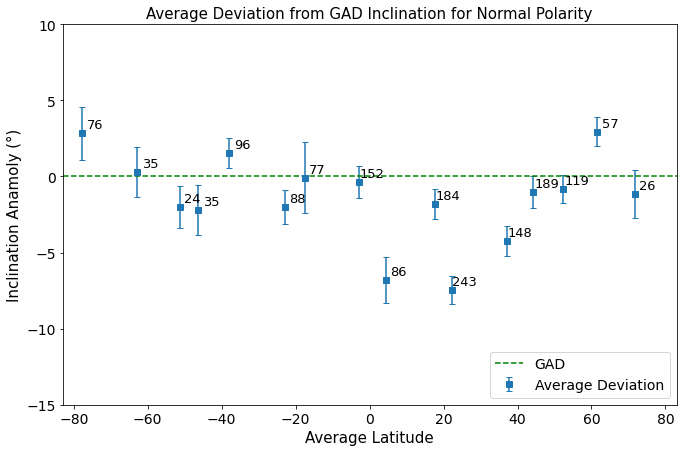

In [23]:
plt.figure(figsize=(11, 7))

plt.xlabel('Average Latitude',fontsize=15)
plt.ylabel('Inclination Anamoly (°)',fontsize=15) 
plt.title('Average Deviation from GAD Inclination for Normal Polarity',fontsize=15)

xs = psv_05N_groups["AvgLat"]
ys = psv_05N_groups["new_ΔI"]
ls = pd.to_numeric(pd.Series(psv_05N_groups["GroupAmount"]))

plt.plot(xs, ys, '.r')

#zip joins x and y coordinates in pairs
for label, x, y in zip(ls, xs, ys):
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(13,5), ha = 'center', fontsize=13)


# curve fit
#z = np.polyfit(xs, ys, 5)
#zpoly = np.poly1d(z)
#plt.plot(xs, zpoly(xs), c = '0.85')  

plt.errorbar(xs, ys, yerr = np.abs(psv_05N_groups['ΔIstdv_weighted']), fmt = 's', capsize=3,label='Average Deviation')
plt.axhline(y=0, color='g', linestyle='--',label='GAD');
plt.ylim([-15, 10]);
plt.xlim([-83, 83]);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14,loc=4);
plt.savefig('../../figs/' + 'PSV10_avg_05NR_inc_resid.png', dpi=150)

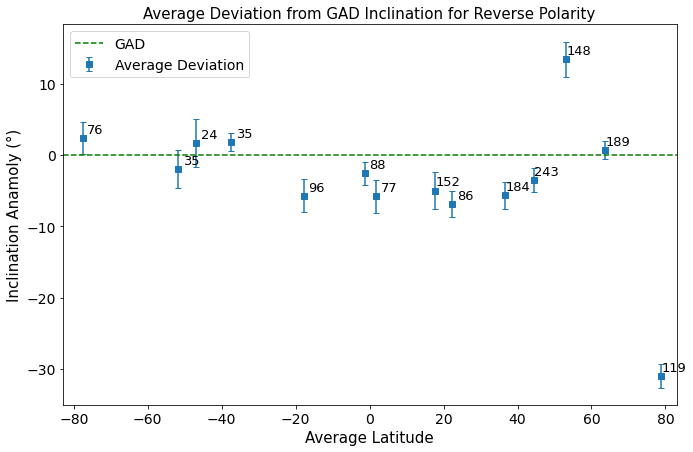

In [24]:
plt.figure(figsize=(11, 7))

plt.xlabel('Average Latitude',fontsize=15)
plt.ylabel('Inclination Anamoly (°)',fontsize=15) 
plt.title('Average Deviation from GAD Inclination for Reverse Polarity',fontsize=15)

xs = psv_05R_groups["AvgLat"]
ys = psv_05R_groups["new_ΔI"]
ls = pd.to_numeric(pd.Series(psv_05N_groups["GroupAmount"]))

plt.plot(xs, ys, '.r')

#zip joins x and y coordinates in pairs
for label, x, y in zip(ls, xs, ys):
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(13,5), ha = 'center', fontsize=13)


# curve fit
#z = np.polyfit(xs, ys, 5)
#zpoly = np.poly1d(z)
#plt.plot(xs, zpoly(xs), c = '0.85')  

plt.errorbar(xs, ys, yerr = np.abs(psv_05R_groups['ΔIstdv_weighted']), fmt = 's', capsize=3,label='Average Deviation')
plt.axhline(y=0, color='g', linestyle='--',label='GAD');
#plt.ylim([-15, 10]);
plt.xlim([-83, 83]);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14,loc='best');
plt.savefig('../../figs/' + 'PSV10_avg_05NR_inc_resid.png', dpi=150)

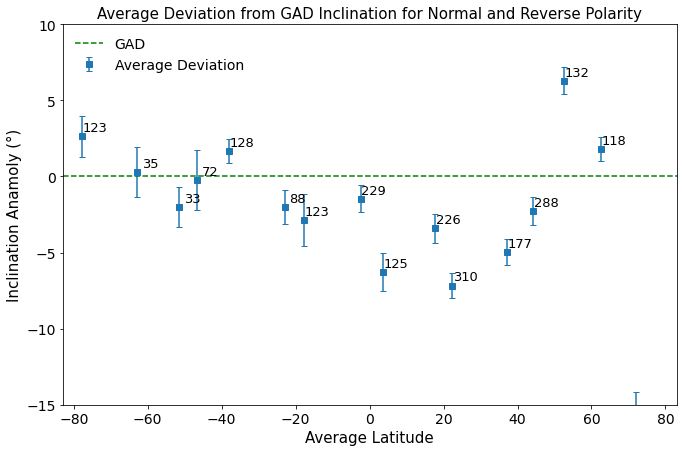

In [25]:
plt.figure(figsize=(11, 7))

plt.xlabel('Average Latitude',fontsize=15)
plt.ylabel('Inclination Anamoly (°)',fontsize=15) 
plt.title('Average Deviation from GAD Inclination for Normal and Reverse Polarity',fontsize=15)

xs = psv_05NR_groups["AvgLat"]
ys = check["mean"]
ls = pd.to_numeric(pd.Series(psv_05NR_groups["GroupAmount"]))

plt.plot(xs, ys, '.r')

#zip joins x and y coordinates in pairs
for label, x, y in zip(ls, xs, ys):
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(13,5), ha = 'center', fontsize=13)


# curve fit
#z = np.polyfit(xs, ys, 5)
#zpoly = np.poly1d(z)
#plt.plot(xs, zpoly(xs), c = '0.85')  

plt.errorbar(xs, ys, yerr = np.abs(psv_05NR_groups['ΔIstdv_weighted']), fmt = 's', capsize=3,label='Average Deviation')
plt.axhline(y=0, color='g', linestyle='--',label='GAD');
plt.ylim([-15, 10]);
plt.xlim([-83, 83]);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14,loc='best', frameon=False);
plt.savefig('../../figs/' + 'PSV10_avg_05NR_inc_resid.png', dpi=150)

This plot is being compared to:


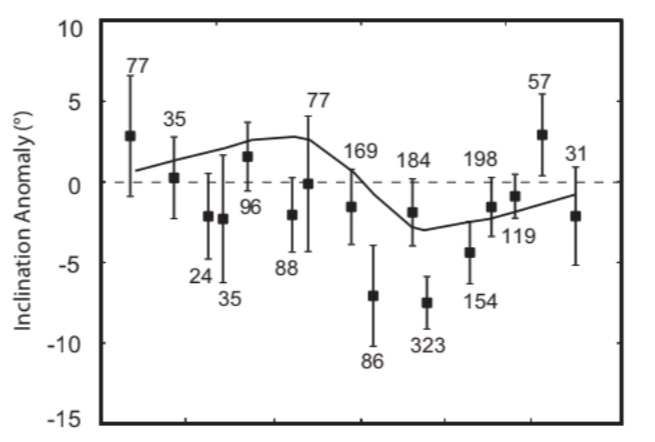

In [26]:
print('This plot is being compared to:')
Image(filename='IncAnamoly_8b_Cromwell.png')

### This plot depicts the average weighted residuals with weighted uncertainty. The group amounts are labeled for each point. The grey line is a curve of best fit. 

NameError: name 'df_groups' is not defined

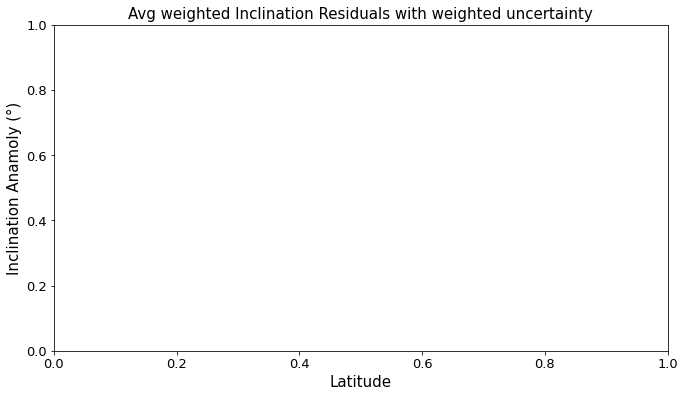

In [27]:
plt.figure(figsize=(11, 6))

plt.xlabel('Latitude', fontsize=15)
plt.ylabel('Inclination Anamoly (°)',fontsize=15) 
plt.title('Avg weighted Inclination Residuals with weighted uncertainty',fontsize=15)
plt.tick_params(axis='x',labelsize=13)
plt.tick_params(axis='y',labelsize=13)

xs = df_groups["AvgLat"]
ys = df_groups["new_ΔI"]
ls = pd.to_numeric(pd.Series(df_groups["GroupAmount"]))

plt.plot(xs, ys, 'r^')

z = np.polyfit(xs, ys, 5)
zpoly = np.poly1d(z)
plt.plot(xs, zpoly(xs), c = '0.85')   # curve fit

plt.errorbar(xs, ys, yerr = np.abs(df_groups['ΔIstdv_weighted']), fmt = '^')
plt.axhline(y=0, color='g')
plt.ylim([-15, 10])

#plt.savefig('../figs/' + 'psv_ma_10degbins_avgresidualsweighted_vs_latitude.png', dpi=150)

### This plots the average locations for the PINT data, psv with 16 data bins, and psv with 34 data bins.

In [ ]:
#avg locations 

plt.figure(figsize=(11, 6))
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=180))


gl=ax.gridlines(crs=ccrs.PlateCarree(),color='black',linewidth=1,linestyle='dotted')
gl.top_labels = False
gl.ylocator=mticker.FixedLocator(np.arange(-90,91,30))
gl.xlocator=mticker.FixedLocator(np.arange(0,400,30));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('Average locations of past 5Ma - psv and PINT')

ax.add_feature(OCEAN,color='lightblue')
ax.add_feature(LAND,color='green')
ax.add_feature(LAKES,facecolor='lightblue',edgecolor='black')
ax.plot([df_groups.AvgLong.values],[df_groups.AvgLat.values],marker='o',color='blue',\
        markersize=10,transform=ccrs.Geodetic(), markeredgecolor='black')

pintgroups = pd.read_pickle("../PINT/PINT_AvgGroups.pkl")
ax.plot([pintgroups.AvgLong.values],[pintgroups.AvgLat.values],marker='o',color='red',\
        markersize=10,transform=ccrs.Geodetic(),markeredgecolor='black')

import matplotlib.patches as mpatches
psv_16 = mpatches.Patch(color='blue', label='psv_16')
PINT = mpatches.Patch(color='red', label='PINT')
plt.legend(handles=[psv_16,PINT])

ax.set_global()

ax.coastlines();

#plt.savefig('../figs/' + 'psvboth-PINTavglocations5ma.png', dpi=150)

### This plots the average latitudes for the PINT data, psv with 16 data bins, and psv with 34 data bins

In [ ]:
#avg latitudes 
plt.figure(figsize=(11, 6))
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-90))


gl=ax.gridlines(crs=ccrs.PlateCarree(),color='black',linewidth=1,linestyle='dotted')
gl.top_labels = False
gl.ylocator=mticker.FixedLocator(np.arange(-90,91,30))
gl.xlocator=mticker.FixedLocator(np.arange(0,400,30));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('PSV - Average latitudes of past 5Ma N')

ax.add_feature(OCEAN,color='lightblue')
ax.add_feature(LAND,color='green')
ax.add_feature(LAKES,facecolor='lightblue',edgecolor='black')

#all0-5N data
ax.plot(-90,[psvnew.Model_lat.values],marker='o',color='blue',\
        markersize=8,transform=ccrs.Geodetic(), markeredgecolor='black')

# groups 
ax.plot(-84,[df_avgdn.AvgLat.values],marker='s',color='yellow', \
        markersize=8,transform=ccrs.Geodetic(), markeredgecolor='black')

import matplotlib.patches as mpatches
psv10 = mpatches.Patch(color='blue', label='PSV10')
binned = mpatches.Patch(color='Yellow', label='Binned Data')
plt.legend(handles=[psv10,binned])

ax.set_global()

ax.coastlines();

plt.savefig('../../figs/' + 'psv_avglats_map.png', dpi=150)

# try some soure of plot?

In [ ]:
plt.figure(figsize=(3, 11));

plt.scatter(np.ones(1635),psvnew.Model_lat.values, marker='^', color='blue',label='PSV10', s=10)
plt.scatter(np.zeros(16),df_avgdn.AvgLat.values, marker='s', color='y', label='Data \nGroups')

plt.xlim([-1, 2])
plt.ylim([83, -83])
plt.yticks(fontsize=14)
plt.xticks(fontsize=0)

plt.axhline(y=-70, marker='_',color='lightgray')
plt.axhline(y=-60, marker='_',color='lightgray')
plt.axhline(y=-50, marker='_',color='lightgray')
plt.axhline(y=-40, marker='_',color='lightgray')
plt.axhline(y=-30, marker='_',color='lightgray')
plt.axhline(y=-20, marker='_',color='lightgray')
plt.axhline(y=-10, marker='_',color='lightgray')
plt.axhline(y=0, marker='_',color='lightgray')
plt.axhline(y=70, marker='_',color='lightgray')
plt.axhline(y=60, marker='_',color='lightgray')
plt.axhline(y=50, marker='_',color='lightgray')
plt.axhline(y=40, marker='_',color='lightgray')
plt.axhline(y=30, marker='_',color='lightgray')
plt.axhline(y=20, marker='_',color='lightgray')
plt.axhline(y=10, marker='_',color='lightgray')

plt.ylabel('Latitude', fontsize=15)
plt.xticks(rotation=90)

plt.title('PSV10, N, \nLatitude Binning Method',fontsize=15)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1);
plt.savefig('../../figs/' + 'psv_05N_avglats_plot.png', dpi=200,pad_inches=0.3);

In [ ]:
data = df_groups.copy()

data["AvgLat"] = pd.to_numeric(data["AvgLat"]) #convert AvgLat values from dtype objects to float64 
data["AvgLong"] = pd.to_numeric(data["AvgLong"]) #convert AvgLong values from dtype objects to float64 

data["ResidualWeighted"] = data["ΔIAvg"]/data["ΔIstdvWeighted"] 
data["Residual"] = data["ΔIAvg"]/data["ΔIstdv"] 

data